In [2]:
Dataset_size = 10000
g_star = 'both'       # low or high or both
model = 'WS'     # FC or WS
g_known = False   # True or False
BATCH_SIZE = 100
C = 5
Epochs = 500

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from keras.datasets import mnist
import pickle
import random
import math
import tensorflow as tf
import os



class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    
class Model_h(nn.Module):
    def __init__(self):
        super(Model_h, self).__init__()
        
        if(model == 'FC') :
            self.W = nn.Parameter(torch.tensor(np.zeros((10,10)), dtype = torch.float, requires_grad = True))
        elif(model == 'WS') :
            self.W = nn.Parameter(torch.tensor(np.zeros((1,10)), dtype = torch.float, requires_grad = True))
            
        torch.nn.init.xavier_uniform_(self.W)
        
    def forward(self, inputs):
        
        x = inputs * self.W
        x = torch.tanh(x)
        x = x.sum(dim = -1)
        
        return x

class Model_g(nn.Module) :
    def __init__(self, C=1):
        super(Model_g, self).__init__()
        
        self.C = C

        if( not g_known) : 
            self.layer_list = nn.ModuleList()
            self.layer_list.append(nn.Linear(10, 50))
            self.layer_list.append(nn.Linear(50, 1))
        
    def forward(self, inputs):
        
        if(g_known) :
            if(g_star=='low') :
                return inputs[:, 0]
            elif(g_star=='high') :
                return torch.cos(inputs[:, :5].sum(-1))
            elif(g_star=='both') :
                return (inputs[:, 0]*self.C+  torch.cos(inputs[:, :5].sum(-1)))/(C+1)
        else:
            x = self.layer_list[0](inputs)
            x = torch.relu(x)
            x = self.layer_list[1](x)
            return x[:,0]

for d_set in ["gaussian", "mnist"] :

  if(d_set == "gaussian") :
    temp = [True, False]
  else :
    temp =[False]

  for g_known in temp :

    #for g_star in ["low", "high", "both"] :
    for g_star in [ "both"] :
        
      if (g_star == "both") :
        temp2= [ 0.17]
      else :
        temp2 = [1]

      for C in temp2 :

        for model in ['WS', 'FC'] :
          
          print(d_set+"_" +str(C)+"_"+str(g_known)+"_"+model+"_"+g_star)

          np.random.seed(0)

          if (d_set == "gaussian") :
            X = np.random.normal(size = (Dataset_size, 10, 10))
          else :
            (trainX, trainy), (testX, testy) = mnist.load_data()
            trainX = np.expand_dims(trainX, 3)
            print(trainX.shape)

            X = tf.image.extract_patches(trainX, (1, 10, 10, 1), (1, 5, 5, 1), (1,1,1,1), padding='VALID')
            X = np.reshape(X, (-1, 10, 10))
            X = X[np.random.choice(range(X.shape[0]), 10000)]
            mean = np.sum(X, axis = (1,2))/100
            mean = np.reshape(mean, (-1, 1, 1))
            X = X - mean

          U_0 = np.random.normal(size = (10,1))

          X_temp = np.sum(np.tanh(X * U_0.T), axis = -1)

          if(g_star == 'low') :
              Y = X_temp[:, 0]
          if(g_star == 'high') :
              Y = np.cos(np.sum(X_temp[:, :5], axis = -1))
          if(g_star == 'both') :
              Y = X_temp[:, 0]*C + np.cos(np.sum(X_temp[:, :5], axis = -1))
              Y = Y/(C+1)

          g = Model_g(C)
          h = Model_h()

          train_data = trainData(torch.FloatTensor(X), torch.FloatTensor(Y))
          train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
          criteria = nn.MSELoss()
          optimizer = optim.SGD(list(g.parameters())+list(h.parameters()), lr = 0.01)

          g.train()
          h.train()

          res = np.zeros(Epochs)

          for epoch in range(Epochs) :
              epoch_loss = 0
              for X_batch, y_batch in train_loader :
                  optimizer.zero_grad()
                  y_pred = g(h(X_batch))
                  loss = criteria(y_pred, y_batch)
                  loss.backward()
                  optimizer.step()
                  epoch_loss += loss.item()/2
              if(epoch % 50 == 0):
                  print(epoch_loss/len(train_loader))
              res[epoch] = epoch_loss/len(train_loader)

          file = open(".\\Results_ws_new\\"+d_set+"_" +str(C).replace(".","")+"_"+str(g_known)+"_"+model+"_"+g_star, 'wb')
          pickle.dump(res, file)
          file.close()

gaussian_0.17_True_WS_both
0.42148004710674286
0.3281837604939938
1.7014242994264352e-05
6.690796407582411e-08
4.167619019335156e-10
2.97925095288365e-10
2.721647782144565e-10
2.6223451715656763e-10
2.540351937141416e-10
2.488256466148808e-10
gaussian_0.17_True_FC_both
0.4123788395524025
0.3549103298783302
0.3452237577736378
0.3391532039642334
0.33624408215284346
0.3305837436020374
0.3280174106359482
0.327526018768549
0.3273317790031433
0.3271929903328419
gaussian_0.17_False_WS_both
0.22410224184393882
0.18540651693940163
0.18341006204485893
0.18230271443724633
0.17539615511894227
0.13747728399932385
0.08129966910928488
0.0770899574458599
0.074758530408144
0.07256363932043314
gaussian_0.17_False_FC_both
0.22664331659674644
0.18414172023534775
0.18247580617666245
0.18112347140908241
0.179974644780159
0.17895037576556205
0.17784477144479752
0.17660040080547332
0.17562164679169656
0.17474402815103532
mnist_0.17_False_WS_both
(60000, 28, 28, 1)
0.46105061650276186
0.25234878197312355
0.236

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


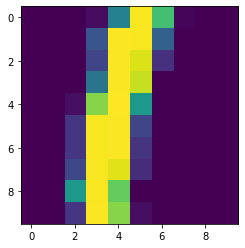

In [19]:
import matplotlib.pyplot as plt
images = X.reshape(-1,10,10)
plt.imshow(images[6])

tensor([  9.0000, -40.6522,   1.0000,  -9.8626,  -9.0000,  18.6474, -19.1624,
          1.0000, -29.0444, -19.5761, -39.8458,   1.0000,  20.4242, -10.7880,
        -39.5106, -30.6536, -39.0604, -41.0000,  40.7367,  11.8707,   1.0000,
        -10.9577, -39.8457, -40.4645, -36.4256,  -9.5896,   0.1406, -40.6663,
        -19.2371,   0.6527,  11.0000, -39.8458, -40.8477, -40.6669, -29.9637,
        -10.4160,  -9.3199,  30.6469, -40.6669, -36.4392, -39.4139, -29.0449,
        -39.0429, -19.5919,  -0.6511, -17.0695, -10.8391, -39.0415, -29.0604,
        -17.2137, -40.6669, -40.6669,  17.4919,  -9.8633,  -0.4162, -39.3531,
        -37.3911, -40.6642, -19.0398, -19.4538,   1.0000,  -0.1455, -40.5503,
        -30.9577,  29.1514,  -1.6513, -29.8449, -30.8486, -40.9626,  10.9365,
        -10.8293,  28.9667,   9.8496, -40.6669, -39.5758,  19.0423,  -9.8457,
        -39.0431,  -5.4312,  -9.1584,   1.0000,   0.1367, -20.1455, -41.0000,
        -19.3396,  -0.4161,   1.0000,   1.0000, -29.3529, -40.61